In [ ]:
import torchtext.vocab as vocab
from torch import tensor
from torch import nn
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

# load file with native open that returns the text list and the associated labels
def load_file(filename):
    '''
    :param filename: name of the file to load
    :return: text list and labels list
    '''
    texts = []
    labels = []
    with open(filename, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            text, label = line.replace("\n","").split(";")
            texts.append(text)
            labels.append(label)
    return texts, labels

# ------------------ LOAD DATA -------------------
txt_train,lbl_train = load_file("train.txt")
txt_test,lbl_test = load_file("test.txt")
txt_val,lbl_val = load_file("val.txt")


In [ ]:
# ----------------- REMOVE STOP WORDS FROM TEXT -----------------
stop_words = set(stopwords.words('english'))
def remove_stop_words(text, stpwd):
    '''
    :param text: text to remove stop words from
    :param stpwd: list of stop words
    :return: text without stop words
    '''
    txt = []
    str = ''
    for i in range(len(text)):
        sentence = text[i]
        for word in sentence.split():
            if word not in stpwd:
                str += word + ' '
        txt.append(str)
        str = ''
    return txt
# ------------------ TF-IDF -------------------
def tf_idf(text):
    ''''
    :param text: text to compute tf-idf
    :return: tf-idf matrix
    '''
    txt = []
    str = ''
    words_used = ' '.join(text).split(' ')
    word_count = dict(Counter(words_used))
    # get words used less than 5 times or more than 1000 times
    words_to_remove = [word for word in word_count if word_count[word] < 5 or word_count[word] > 1000]
    # remove words from text
    for i in range(len(text)):
        sentence = text[i]
        for word in sentence.split():
            if word not in words_to_remove:
                str += word + ' '
        txt.append(str)
        str = ''
    return txt

# ------------------ PREPROCESSING -------------------
txt_train = remove_stop_words(txt_train, stop_words)
txt_val = remove_stop_words(txt_val, stop_words)
txt_test = remove_stop_words(txt_test, stop_words)

txt_train = tf_idf(txt_train)
txt_val = tf_idf(txt_val)
txt_test = tf_idf(txt_test)

txt = txt_train + txt_test + txt_val
lbl = lbl_train + lbl_test + lbl_val

In [ ]:
# ------------------ TOKENIZE -------------------
def yield_tokens(data_iter):
    '''
    :param data_iter: iterator over the data
    :return: yield tokens
    '''
    for text in data_iter:
        yield text.strip().split()

# -------------- BUILD VOCABULARY ----------------
def build_vocab(iterator):
    '''
    :param iterator: iterator over the data
    :return: vocabulary
    '''
    words = yield_tokens(iterator)
    voc = vocab.build_vocab_from_iterator(words, specials=["<unk>"])
    return voc

def transform_vocab_to_tensor(vocab):
    '''
    :param vocab: vocabulary
    :return: tensor of the vocabulary
    '''
    return tensor(list(vocab.get_stoi().values()))

# ------------------ APPLY VOCABULARY -------------------
def apply_vocab_to_labels(labels, vocab):
    '''
    :param labels: labels to apply vocabulary to
    :param vocab: vocabulary
    :return: labels encoded
    '''
    return [vocab[label] for label in labels]

# ------------------ ENCODE LABELS -------------------
def encode_labels(labels, vocab):
    '''
    :param labels: labels to encode
    :param vocab: vocabulary
    :return: encoded labels
    '''
    encoded = list()
    for label in labels:
        encoded_label = vocab[label]
        encoded.append(encoded_label)
    return encoded

# ------------------ ENCODE TEXT -------------------
def encode_text(text, vocab):
    '''
    :param text: text to encode
    :param vocab: vocabulary
    :return: encoded text
    '''
    encoded_reviews = list()
    for sentence in text:
        encoded_review = list()
        for word in sentence.split():
            if word in vocab:
                encoded_review.append(vocab[word])
            else:
                encoded_review.append(vocab["<unk>"])

        encoded_reviews.append(encoded_review)
    return encoded_reviews

# ------------------ MAKE ALL TEXTS THE SAME LENGTH -------------------
def pad_text(encoded, max_length):
    '''
    :param encoded: encoded text
    :param max_length: max length of the text
    :return: padded text
    '''
    padded = list()
    for review in encoded:
        if len(review) < max_length:
            review.extend([0] * (max_length - len(review)))
        elif len(review) > max_length:
            review = review[:max_length]
        padded.append(review)
    return padded

# ------------------ CREATE DATASET -------------------
def get_dataset(text, label, vocab):
    '''
    :param text: text to encode
    :param label: labels to encode
    :param vocab: vocabulary
    :return: dataset
    '''
    encoded_text = encode_text(text, vocab)
    padded_text = pad_text(encoded_text, sentence_length)
    encoded_label = encode_labels(label, label_vocabulary)
    oh_label = nn.functional.one_hot(tensor(encoded_label), len(tensor_label))
    return padded_text, oh_label

# ------------------ ONE HOT ENCODER -------------------
class do_one_hot():
    '''
    :param data: data to encode
    :return: one hot encoded data
    '''
    def __init__(self, numClass):
        self.numClass = numClass
        self.encoder = nn.functional.one_hot

    def make_encodage(self, line):
        return self.encoder(torch.tensor(line).long(), num_classes=self.numClass)


In [ ]:
# ------------------------ RNN -----------------------------
class RNN(nn.Module):
    '''
    :param input_size: size of the input
    :param hidden_size: size of the hidden layer
    :param num_layers: number of layers
    :param num_classes: number of classes
    :return: RNN model
    '''
    def __init__(self, input_size, hidden_size, output_size, emb_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2e = nn.Linear(input_size, emb_size)
        self.i2h = nn.Linear(emb_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(emb_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        dropout = nn.Dropout(p=0.12)
        embedded = self.i2e(input)
        combined = torch.cat((embedded, hidden), 1)
        #dropout(combined)
        hidden = self.i2h(combined)
        #dropout(hidden)
        output = self.i2o(combined)
        #dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, size):
        return torch.zeros(size, self.hidden_size, dtype=torch.long)


In [ ]:
# ------------------ TEXT PROCESSING -------------------
text_vocabulary = build_vocab(txt_train)
tensor_text = transform_vocab_to_tensor(text_vocabulary)

# ------------------ LABEL PROCESSiNG -------------------
label_vocabulary = build_vocab(lbl_train)
# print(label_vocabulary.get_stoi().keys())
tensor_label = transform_vocab_to_tensor(label_vocabulary)
#oh_label = nn.functional.one_hot(tensor_label, len(tensor_label))

# ------------------ HYPERPARAMETERS -------------------
sentence_encoder = do_one_hot(len(tensor_text))
num_epochs = 15
learning_rate = 0.0007
batch_size = 128
sentence_length = 15
input_size = len(tensor_text)
hidden_size = 128
output_size = len(tensor_label)
emb_size = 128

rnn = RNN(input_size, hidden_size, output_size, emb_size)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

# ------------------- FREQUENCY OF LABELS --------------------
freq = Counter(lbl_train)
print(freq)


Counter({'joy': 5362, 'sadness': 4666, 'anger': 2159, 'fear': 1937, 'love': 1304, 'surprise': 572})


In [ ]:
# ------------------ CREATING CUSTOM DATASET -------------------
train_dataset, train_label = get_dataset(txt_train, lbl_train, text_vocabulary)
test_dataset, test_label = get_dataset(txt_test, lbl_test, text_vocabulary)
val_dataset, val_label = get_dataset(txt_val, lbl_val, text_vocabulary)

# ------------------ LOADING DATA -------------------
train_dataset_tuple = TensorDataset(torch.tensor(train_dataset), train_label)
train_dataloader = DataLoader(train_dataset_tuple, batch_size=batch_size, drop_last=True)
# print(train_dataset_tuple[0])

val_dataset_tuple = TensorDataset(torch.tensor(val_dataset), val_label)
val_dataloader = DataLoader(val_dataset_tuple, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset_tuple = TensorDataset(torch.tensor(test_dataset), test_label)
test_dataloader = DataLoader(test_dataset_tuple, batch_size=batch_size, shuffle=True, drop_last=True)


In [ ]:
# ------------------ TRAIN & VAL -------------------
y_train = []
clip = 5
counter = 0
loss_train = []
loss_val = []
acc_train = []
acc_val = []
print("Training for %d epochs..." % num_epochs)
for epoch in range(num_epochs):
    # ------------------ TRAINING -------------------
    rnn.train()
    correct = 0
    total = 0
    count = 0
    loss_train_epoch = []
    list_acc_train = []
    print(" ----------------------------------------------------------------------  ")
    for i, (text, label) in enumerate(train_dataloader):
        hidden = rnn.initHidden(batch_size)
        data_training = sentence_encoder.make_encodage(text)
        rnn.zero_grad()
        for k in range(len(text[0])):
            output, hidden = rnn(data_training[:, k, :].float(), hidden)
        loss = criterion(output, torch.argmax(label, dim=1))
        loss_train_epoch.append(loss.item())
        loss.backward()
        optimizer.step()
        prediction = torch.argmax(output, dim=1)
        for k in range(len(prediction)):
            if prediction[k] == torch.argmax(label[k]):
                correct += 1
            total += 1
        list_acc_train.append(correct / total)
        count += 1
    counter += 1
    print("| Epoch: {}/{} : LOSS = {}".format(epoch + 1, num_epochs, loss),
            "Accuracy = {}".format(correct / total))
    y_train.append(counter)
    loss_train.append(np.mean(loss_train_epoch))
    acc_train.append(np.mean(list_acc_train))

    # ------------------ VALIDATION -------------------
    rnn.eval()
    correct = 0
    total = 0
    count = 0
    loss_val_epoch = []
    list_acc_val = []
    for i, (text, label) in enumerate(val_dataloader):
        hidden = rnn.initHidden(batch_size)
        data_training = sentence_encoder.make_encodage(text)
        rnn.zero_grad()
        for k in range(len(text[0])):
            output, hidden = rnn(data_training[:, k, :].float(), hidden)
        loss = criterion(output, torch.argmax(label, dim=1))
        loss_val_epoch.append(loss.item())
        prediction = torch.argmax(output, dim=1)
        for k in range(len(prediction)):
            if prediction[k] == torch.argmax(label[k]):
                correct += 1
            total += 1
        list_acc_val.append(correct / total)
        count += 1
    print("| EVAL Epoch: {}/{} : EVAL LOSS = {}".format(epoch + 1, num_epochs, loss),
            "EVAL Accuracy = {}".format(correct / total))
    loss_val.append(np.mean(loss_val_epoch))
    acc_val.append(np.mean(list_acc_val))


Training for 15 epochs...
 ----------------------------------------------------------------------  


<ipython-input-6-0f102d945fc2>:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.encoder(torch.tensor(line).long(), num_classes=self.numClass)


| Epoch: 1/15 : LOSS = 1.4277467727661133 Accuracy = 0.3225
| EVAL Epoch: 1/15 : EVAL LOSS = 1.301043152809143 EVAL Accuracy = 0.3614583333333333
 ----------------------------------------------------------------------  
| Epoch: 2/15 : LOSS = 1.08895742893219 Accuracy = 0.439125
| EVAL Epoch: 2/15 : EVAL LOSS = 1.04550302028656 EVAL Accuracy = 0.4635416666666667
 ----------------------------------------------------------------------  
| Epoch: 3/15 : LOSS = 0.9640485048294067 Accuracy = 0.5941875
| EVAL Epoch: 3/15 : EVAL LOSS = 1.134114146232605 EVAL Accuracy = 0.5848958333333333
 ----------------------------------------------------------------------  
| Epoch: 4/15 : LOSS = 0.9065007567405701 Accuracy = 0.688625
| EVAL Epoch: 4/15 : EVAL LOSS = 1.177983283996582 EVAL Accuracy = 0.6364583333333333
 ----------------------------------------------------------------------  
| Epoch: 5/15 : LOSS = 0.6100026369094849 Accuracy = 0.75975
| EVAL Epoch: 5/15 : EVAL LOSS = 0.7435793280601501 EVA

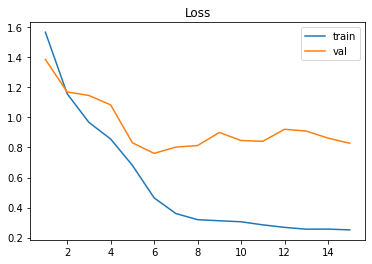

In [ ]:
plt.title("Loss")
plt.plot(y_train, loss_train, label="train")
plt.plot(y_train, loss_val, label="val")
plt.legend()
plt.show()

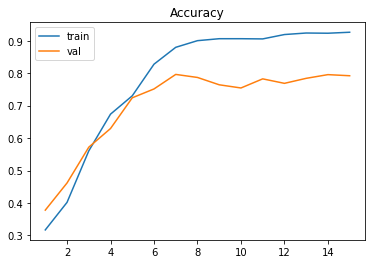

In [ ]:
plt.title("Accuracy")
plt.plot(y_train, acc_train, label="train")
plt.plot(y_train, acc_val, label="val")
plt.legend()
plt.show()

In [ ]:
# ------------------ TEST & CONFUSION MATRIX -------------------
rnn.eval()
correct = 0
total = 0
count = 0
loss_test_epoch = []
list_acc_test = []
list_pred = []
list_label = []
print("Testing...")
print(" ----------------------------------------------------------------------  ")
for i, (text, label) in enumerate(test_dataloader):
    hidden = rnn.initHidden(batch_size)
    data_training = sentence_encoder.make_encodage(text)
    rnn.zero_grad()
    for k in range(len(text[0])):
        output, hidden = rnn(data_training[:, k, :].float(), hidden)
    loss = criterion(output, torch.argmax(label, dim=1))
    loss_test_epoch.append(loss.item())
    prediction = torch.argmax(output, dim=1)
    for k in range(len(prediction)):
        if prediction[k] == torch.argmax(label[k]):
            correct += 1
        total += 1
        list_pred.append(prediction[k])
        list_label.append(torch.argmax(label[k]))
    list_acc_test.append(correct / total)
    count += 1
print("TEST Epoch: {}/{} : TEST LOSS = {}".format(epoch + 1, num_epochs, loss),
        "TEST Accuracy = {}".format(correct / total))


Testing...
 ----------------------------------------------------------------------  


<ipython-input-6-0f102d945fc2>:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.encoder(torch.tensor(line).long(), num_classes=self.numClass)


TEST Epoch: 15/15 : TEST LOSS = 0.8306346535682678 TEST Accuracy = 0.7645833333333333


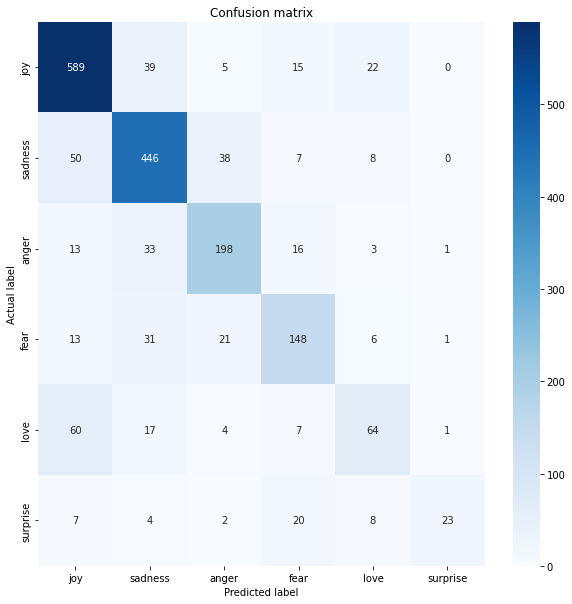

In [ ]:
#print(list_label)
#print(list_pred)
list_label = [int(t) for t in list_label]
list_pred = [int(t) for t in list_pred]
cm = confusion_matrix(list_label, list_pred)
#print(cm)
plt.figure(figsize=(10, 10))
axis_labels = ["joy", "sadness", "anger", "fear", "love", "surprise"]
sns.heatmap(cm, annot=True, xticklabels=axis_labels, yticklabels=axis_labels, fmt="d", cmap="Blues")
plt.title("Confusion matrix")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.savefig("confusion_matrix.png")
plt.show()